In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import re
import os

plt.style.use("seaborn-v0_8")

In [24]:
def extract_position(df, mutation_col="Mutation"):
    """
    Extracts numeric residue position from mutation strings like 'A123G'.
    Creates a new column: 'Position'
    """
    df = df.copy()
    df["Position"] = df[mutation_col].str.extract(r"(\d+)").astype(float)
    return df

In [25]:
def merge_rsa(rsa_df, dataset_df, rsa_key="ResNum", data_key="Position"):
    """
    Merges RSA table with the dataset based on residue number.
    """
    merged = pd.merge(dataset_df, rsa_df, left_on=data_key, right_on=rsa_key, how="left")
    return merged


In [26]:
def compute_rsa_correlations(merged_df, outcome_cols):
    """
    Computes Spearman correlation between RSA and each outcome variable.
    Returns a dataframe of correlations.
    """
    results = []

    for col in outcome_cols:
        valid = merged_df[[col, "RSA"]].dropna()
        if len(valid) < 3:
            continue
        
        rho, p = spearmanr(valid[col], valid["RSA"])
        results.append({
            "Outcome": col,
            "Spearman_rho": rho,
            "p_value": p,
            "SampleSize": len(valid)
        })

    return pd.DataFrame(results)


In [27]:
def plot_scatter_panel(merged_df, outcome_cols, title_prefix, save_path=None):
    """
    Makes a multi-panel scatter plot of RSA vs outcome columns.
    """
    n = len(outcome_cols)
    rows = int(np.ceil(n / 2))
    
    fig, axes = plt.subplots(rows, 2, figsize=(12, 5*rows))
    axes = axes.flatten()

    for i, col in enumerate(outcome_cols):
        ax = axes[i]
        sns.regplot(
            data=merged_df,
            x="RSA",
            y=col,
            scatter_kws={"alpha": 0.6},
            ax=ax
        )
        ax.set_title(f"{col} vs RSA")

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


In [ ]:
RSA_FILE = "processed_data/PSEN1_AF3_RSA.csv"
DATASET_FILE = "raw_data/PSEN1_Sun.csv"

OUTCOME_COLUMNS = ["AAO", "Total Activity", "Amount of Ab42", "Amount of Ab40", "Ab42/Ab40 ratio"]
OUTPUT_FILE = "processed_data/PSEN1_Sun_RSA_Correlation.csv"
OUTPUT_FIGURE = "figures/PSEN1_Sun_RSA_Correlation"

In [29]:
rsa_df = pd.read_csv(RSA_FILE)
dataset_df = pd.read_csv(DATASET_FILE)


In [30]:
dataset_df = extract_position(dataset_df, mutation_col="Mutation")
dataset_df.head()


,Variants,Mutation,AAO,Total Activity,SD of Total Activity,Ab42/Ab40 ratio,SD of ratio,Amount of Ab40,SD of Ab40,Amount of Ab42,...,fathmm-XF_coding_score,fathmm-XF_coding_rankscore,fathmm-XF_coding_pred,Eigen-raw_coding,Eigen-raw_coding_rankscore,Eigen-phred_coding,Eigen-PC-raw_coding,Eigen-PC-raw_coding_rankscore,Eigen-PC-phred_coding,Position
0,PSEN1:p.Arg35Gln,R35Q,59.0,0.430,0.031,1.449,0.267,0.423,0.032,0.673,...,0.361677,0.44935,N,-0.683929,0.16279,0.839981,-0.500256,0.21837,1.201499,35.0
1,PSEN1:p.Ala79Val,A79V,61.2,0.013,0.002,NaN,NaN,0.008,0.001,0.056,...,0.928313,0.91201,D,0.837492,0.88323,9.558504,0.766865,0.87344,9.212799,79.0
2,PSEN1:p.Val82Leu,V82L,55.0,0.596,0.018,0.813,0.070,0.608,0.016,0.516,...,0.943348,0.94891,D,0.899956,0.91712,11.048510,0.847559,0.92834,11.683780,82.0
3,PSEN1:p.Leu85Pro,L85P,26.0,0.020,0.001,NaN,NaN,0.011,0.001,0.177,...,0.966048,0.98840,D,0.907138,0.92061,11.235850,0.825157,0.91439,10.910840,85.0
4,PSEN1:p.Val89Leu,V89L,48.6,0.188,0.009,2.526,0.235,0.162,0.006,0.417,...,0.945304,0.95328,D,1.007236,0.95941,14.151250,0.930148,0.96740,15.105730,89.0


In [31]:
merged_df = merge_rsa(rsa_df, dataset_df)
merged_df.head()


,Variants,Mutation,AAO,Total Activity,SD of Total Activity,Ab42/Ab40 ratio,SD of ratio,Amount of Ab40,SD of Ab40,Amount of Ab42,...,Eigen-raw_coding_rankscore,Eigen-phred_coding,Eigen-PC-raw_coding,Eigen-PC-raw_coding_rankscore,Eigen-PC-phred_coding,Position,ResNum,AA,ACC,RSA
0,PSEN1:p.Arg35Gln,R35Q,59.0,0.430,0.031,1.449,0.267,0.423,0.032,0.673,...,0.16279,0.839981,-0.500256,0.21837,1.201499,35.0,35,R,199,0.751
1,PSEN1:p.Ala79Val,A79V,61.2,0.013,0.002,NaN,NaN,0.008,0.001,0.056,...,0.88323,9.558504,0.766865,0.87344,9.212799,79.0,79,A,51,0.421
2,PSEN1:p.Val82Leu,V82L,55.0,0.596,0.018,0.813,0.070,0.608,0.016,0.516,...,0.91712,11.048510,0.847559,0.92834,11.683780,82.0,82,V,32,0.194
3,PSEN1:p.Leu85Pro,L85P,26.0,0.020,0.001,NaN,NaN,0.011,0.001,0.177,...,0.92061,11.235850,0.825157,0.91439,10.910840,85.0,85,L,1,0.005
4,PSEN1:p.Val89Leu,V89L,48.6,0.188,0.009,2.526,0.235,0.162,0.006,0.417,...,0.95941,14.151250,0.930148,0.96740,15.105730,89.0,89,V,1,0.006


In [32]:
correlation_results = compute_rsa_correlations(merged_df, OUTCOME_COLUMNS)
correlation_results

,Outcome,Spearman_rho,p_value,SampleSize
0,AAO,0.127785,0.173526,115
1,Total Activity,0.214786,0.015727,126
2,Amount of Ab42,0.193387,0.030033,126
3,Amount of Ab40,0.198930,0.025542,126
4,Ab42/Ab40 ratio,-0.188648,0.068618,94


In [33]:
# correlation_results.to_csv("RSA_outcome_correlations.csv", index=False)


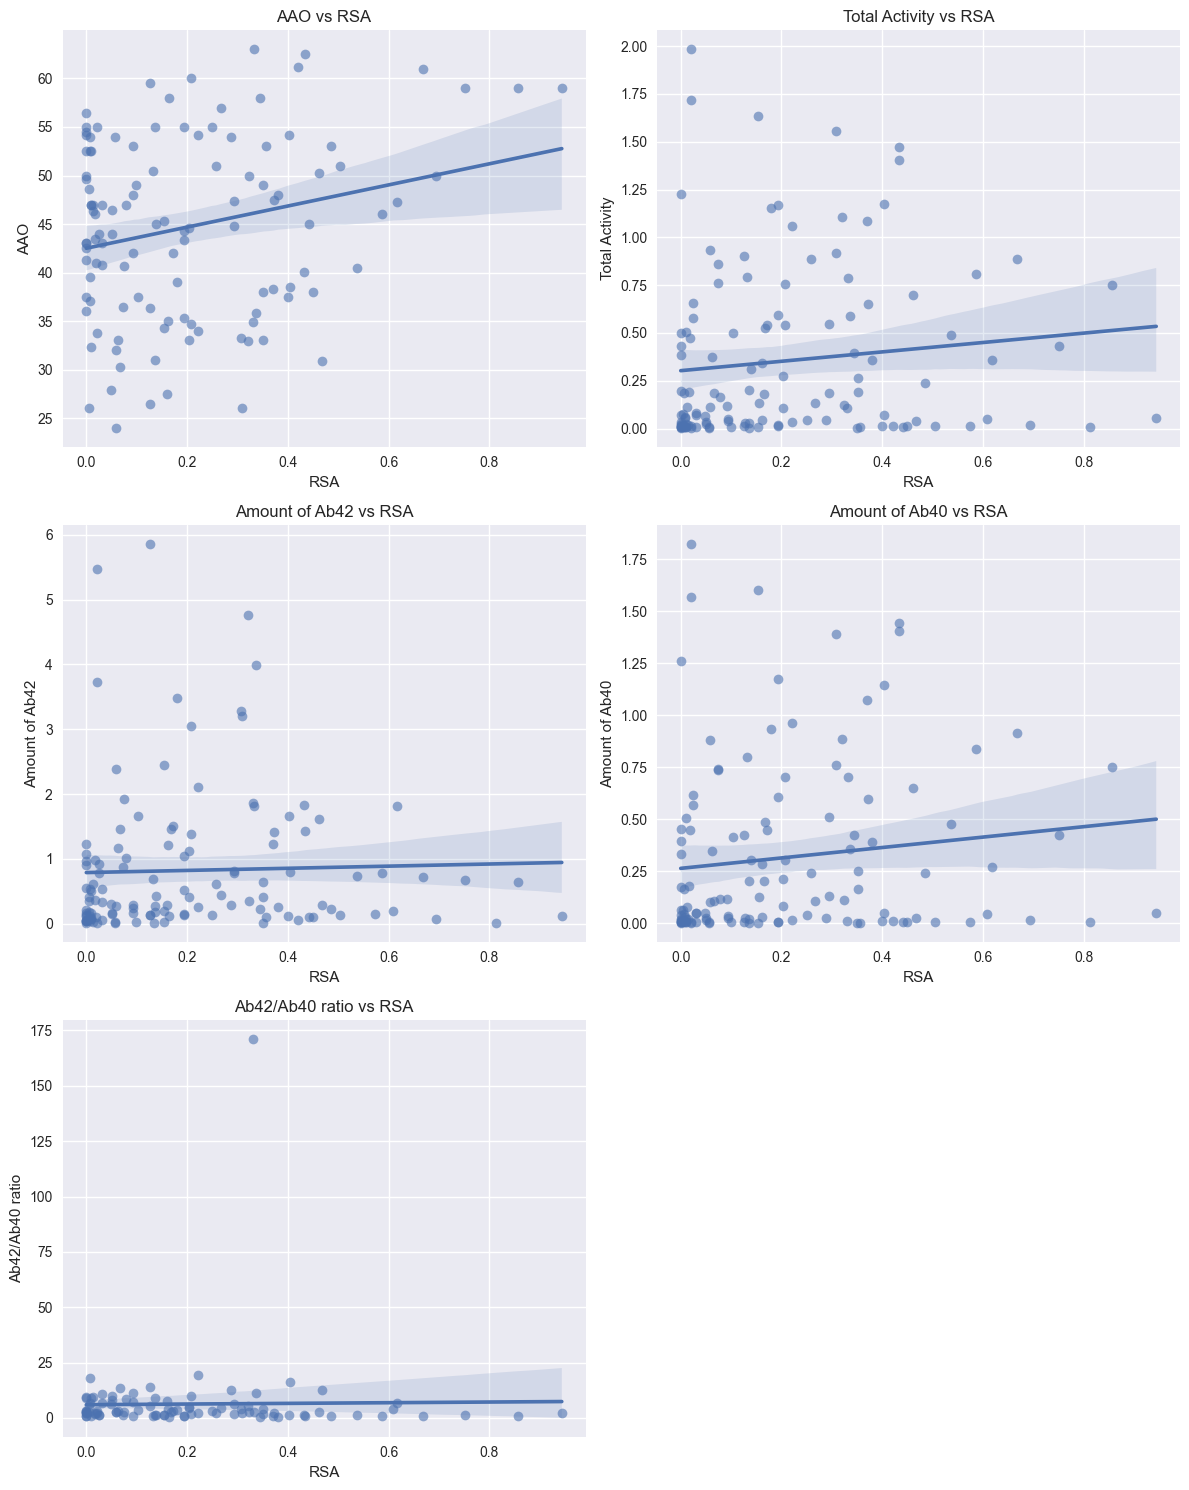

In [34]:
plot_scatter_panel(
    merged_df,
    OUTCOME_COLUMNS,
    title_prefix="PSEN1_Sun",
    save_path="PSEN1_Sun_RSA_scatter_panel.png"
)
